In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!rm -rf aclImdb/train/unsup

--2025-05-01 18:46:58--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  14.0MB/s    in 16s     

2025-05-01 18:47:14 (4.97 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [8]:
# Fine-tuning a Pretrained Backbone with Keras NLP
# This notebook demonstrates how to fine-tune a pretrained backbone for sentiment analysis
# --- VERSION WITH CORRECTIONS ---

import tensorflow as tf
import keras_nlp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import os # Added for checking dataset directory

print("TensorFlow version:", tf.__version__)
print("Keras NLP version:", keras_nlp.__version__)

# --- Configuration ---
# NOTE: You might need to download and extract the aclImdb dataset first.
# You can often find it here: https://ai.stanford.edu/~amaas/data/sentiment/
# Download aclImdb_v1.tar.gz and extract it so you have an 'aclImdb' directory.
dataset_dir = "aclImdb" # Make sure this directory exists in your Colab environment
if not os.path.exists(dataset_dir):
    print(f"ERROR: Dataset directory '{dataset_dir}' not found.")
    print("Please download the IMDB dataset (aclImdb_v1.tar.gz) and extract it.")
    # Or uncomment below to try downloading and extracting (requires internet)
    # print("Attempting to download and extract dataset...")
    # !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    # !tar -xzf aclImdb_v1.tar.gz
    if not os.path.exists(dataset_dir):
      raise FileNotFoundError(f"Dataset directory '{dataset_dir}' still not found after download attempt.")


batch_size = 32 # You can adjust this based on your GPU memory
max_sequence_length = 512 # Max length for BERT sequences

# --- 1. Load and Prepare Dataset ---
print("\n=== 1. Loading and Preparing Dataset ===")

# Load raw text data directly into tf.data.Dataset objects
# FIX: Corrected unpacking of the returned tuple
train_ds, validation_ds = keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="both", # Use "both" to get train and validation sets
    seed=42,
)

print(f"Training dataset specs: {train_ds.element_spec}")
print(f"Validation dataset specs: {validation_ds.element_spec}")

# Apply caching and prefetching for performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# FIX: Removed the loops unpacking datasets into Python lists.
# We will use train_ds and validation_ds directly.

# (Optional) Print some examples directly from the dataset
print("\nSample training examples (from tf.data.Dataset):")
for text_batch, label_batch in train_ds.take(1): # Take one batch
    for i in range(3): # Show first 3 examples in the batch
        sentiment = "Positive" if label_batch.numpy()[i] == 1 else "Negative"
        print(f"Example {i+1}: {sentiment}")
        print(f"Text: {text_batch.numpy()[i].decode('utf-8')[:100]}...")
        print()


# --- 2. Load Pretrained Backbone & Preprocessor ---
print("\n=== 2. Loading Pretrained BERT Backbone & Preprocessor ===")

# Define preprocessing layer - aligns input text with BERT's requirements
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=max_sequence_length,
)

# Load the backbone model (the main BERT layers without a specific head)
backbone = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")


# --- 3. Build the Fine-tuning Model ---
print("\n=== 3. Building the Fine-tuning Model ===")

# FIX: Define input layer expecting scalar strings (shape=())
inputs = keras.Input(shape=(), dtype="string", name="text_input")

# Preprocessing: Tokenize, add special tokens, pad/truncate
preprocessed_inputs = preprocessor(inputs)

# Feed preprocessed inputs to the backbone
# FIX: Correctly handle dictionary output and access sequence output
backbone_outputs = backbone(preprocessed_inputs)
sequence_output = backbone_outputs["sequence_output"]

# Extract the [CLS] token output (index 0) for classification
# FIX: Apply slice to the sequence_output tensor
cls_output = sequence_output[:, 0, :]

# Add a dropout layer for regularization
intermediate_output = keras.layers.Dropout(0.1)(cls_output)

# Add the final classification head (1 neuron for binary sentiment, sigmoid activation)
outputs = keras.layers.Dense(1, activation="sigmoid", name="classifier_head")(intermediate_output)

# Create the final Keras model
model = keras.Model(inputs, outputs)

# Print model summary to verify connections
model.summary()


# --- 4. Initial Training with Frozen Backbone ---
print("\n=== 4. Training with Frozen Backbone (Warm-up) ===")
print("Initially freezing the backbone layers...")

# Freeze the backbone layers to train only the new head initially
backbone.trainable = False

# Compile the model with frozen backbone
# Use a slightly higher learning rate for the head
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    jit_compile=False # <--- ADD THIS
)

# Train for a few epochs with frozen backbone
initial_epochs = 2
print(f"Training head for {initial_epochs} epochs...")

start_time = time.time()
# FIX: Pass tf.data.Dataset directly, remove batch_size argument
history_frozen = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
)
end_time = time.time()
print(f"Time taken for training with frozen backbone: {end_time - start_time:.2f} seconds")


# --- 5. Fine-tuning the Entire Model ---
print("\n=== 5. Fine-tuning the Entire Model ===")
print("Unfreezing the backbone layers...")

# Unfreeze the backbone
backbone.trainable = True

# Recompile with a lower learning rate for fine-tuning the whole model
# It's crucial to recompile after changing trainable status
# Recompile with a lower learning rate for fine-tuning the whole model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    jit_compile=False # <--- ADD THIS
)

# Verify trainable status (optional)
# model.summary()

# Continue training with unfrozen backbone
print("\nContinuing training (fine-tuning) with unfrozen backbone...")
fine_tune_epochs = 3
total_epochs = initial_epochs + fine_tune_epochs

start_time = time.time()
# FIX: Pass tf.data.Dataset directly, remove batch_size, use initial_epoch
history_unfrozen = model.fit(
    train_ds,
    epochs=total_epochs, # Train until the total number of epochs
    initial_epoch=initial_epochs, # Start counting from here
    validation_data=validation_ds,
)
end_time = time.time()
print(f"Time taken for fine-tuning: {end_time - start_time:.2f} seconds")


# --- 6. Visualize Training History ---
print("\n=== 6. Visualizing Training History ===")

# Combine the histories for plotting
history = {}
# Check if keys exist before accessing (robustness)
if "accuracy" in history_frozen.history and "accuracy" in history_unfrozen.history:
    history["accuracy"] = history_frozen.history["accuracy"] + history_unfrozen.history["accuracy"]
    history["val_accuracy"] = history_frozen.history["val_accuracy"] + history_unfrozen.history["val_accuracy"]
    history["loss"] = history_frozen.history["loss"] + history_unfrozen.history["loss"]
    history["val_loss"] = history_frozen.history["val_loss"] + history_unfrozen.history["val_loss"]
else:
    print("Warning: Could not combine histories completely. Plotting might be incomplete.")
    # Fallback or plot separately if needed
    history = history_unfrozen.history # Plot only the fine-tuning part if frozen part failed

# Plot accuracy and loss curves if history is available
if history:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Training Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.axvline(x=initial_epochs-1, color="r", linestyle="--", label="Start Fine Tuning")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.axvline(x=initial_epochs-1, color="r", linestyle="--", label="Start Fine Tuning")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plotting as history data is missing.")


# --- 7. Final Model Evaluation ---
print("\n=== 7. Final Model Evaluation ===")
# FIX: Evaluate using the validation dataset
loss, accuracy = model.evaluate(validation_ds)
print(f"Final Validation Accuracy: {accuracy:.4f}")
print(f"Final Validation Loss: {loss:.4f}")


# --- 8. Testing on New Examples ---
print("\n=== 8. Testing on New Examples ===")

test_examples = [
    "This movie was fantastic! I really enjoyed the plot and the acting was superb.",
    "What a waste of time. Poor acting, terrible script, and boring storyline.",
    "The movie had good special effects but the story was somewhat confusing.",
    "I fell asleep halfway through the movie.",
    "The characters were well-developed and the dialogue was engaging."
]

predictions = model.predict(test_examples) # Use predict on the list of strings

for i, (text, pred) in enumerate(zip(test_examples, predictions)):
    sentiment = "Positive" if pred[0] >= 0.5 else "Negative"
    confidence = pred[0] if sentiment == "Positive" else 1 - pred[0]
    print(f"\nExample {i+1}: {text}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.4f})")


# --- 9. Saving the Fine-tuned Model ---
print("\n=== 9. Saving the Fine-tuned Model ===")
# Use the .keras extension for Keras 3 native format
model_save_path = "./fine_tuned_bert_sentiment.keras"
try:
    model.save(model_save_path)
    print(f"Model saved successfully to {model_save_path}")

    # Optional: Test loading the saved model
    print("\nTesting loading the saved model...")
    loaded_model = keras.models.load_model(model_save_path)
    print("Model loaded successfully.")
    loaded_pred = loaded_model.predict(["A quick test after loading."])
    print(f"Test prediction with loaded model: {loaded_pred[0][0]:.4f}")

except Exception as e:
    print(f"Error saving or loading model: {e}")


# --- Tips ---
print("\n=== Tips for Improving Fine-tuning Results ===")
print("1. Use longer training with more epochs (monitor validation loss for overfitting)")
print("2. Experiment with different learning rates or learning rate schedules (e.g., linear decay)")
print("3. Try larger batch sizes if your GPU memory allows")
print("4. Explore gradual unfreezing (unfreeze layer groups incrementally)")
print("5. Apply techniques like weight decay")
print("6. Use longer maximum sequence length if needed and memory allows")
print("7. Consider data augmentation techniques for text (e.g., back-translation, synonym replacement)")
print("8. Try different pretrained backbones (e.g., RoBERTa, DistilBERT, ELECTRA)")

print("\nComplete! You've successfully fine-tuned a pretrained BERT backbone for sentiment analysis.")

TensorFlow version: 2.18.0
Keras NLP version: 0.18.1

=== 1. Loading and Preparing Dataset ===
Found 50005 files belonging to 2 classes.
Using 40004 files for training.
Using 10001 files for validation.
Training dataset specs: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset specs: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Sample training examples (from tf.data.Dataset):
Example 1: Positive
Text: The film is not visually stunning in the conventional sense. It doesn't present a series of pretty p...

Example 2: Positive
Text: Some nice scenery, but the story itself--in which a self-proclaimed Egyptologist (Lesley-Anne Down) ...

Example 3: Negative
Text: I had to read I Know Why The Caged Birds Sing in my English class and we watched the movie after fin...


=== 2. Loading Pretrained BERT Backbone & Preprocessor ===

=== 3. Building the Fin

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_text_classifi… │ [(None, 512),     │          0 │ text_input[0][0]  │
│ (BertTextClassifie… │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 109,482,2… │ bert_text_classi… │
│ (BertBackbone)      │ (None, 512, 768)] │            │ bert_text_classi… │
│                     │                   │            │ bert_text_classi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 768)       │          0 │ bert_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 768)       │          0 │ get_item_9[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 1)         │        769 │ dropout_75[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,483,009 (417.64 MB)

 Trainable params: 109,483,009 (417.64 MB)

 Non-trainable params: 0 (0.00 B)


=== 4. Training with Frozen Backbone (Warm-up) ===
Initially freezing the backbone layers...
Training head for 2 epochs...
Epoch 1/2
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1236s 974ms/step - accuracy: 0.4973 - loss: 0.7134 - val_accuracy: 0.4970 - val_loss: 0.6992
Epoch 2/2
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1216s 972ms/step - accuracy: 0.5052 - loss: 0.7057 - val_accuracy: 0.5071 - val_loss: 0.6970
Time taken for training with frozen backbone: 2451.94 seconds

=== 5. Fine-tuning the Entire Model ===
Unfreezing the backbone layers...

Continuing training (fine-tuning) with unfrozen backbone...
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['pooled_dense/kernel', 'pooled_dense/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


ResourceExhaustedError: Graph execution error:

Detected at node functional_3_1/bert_backbone_1/transformer_layer_8_1/self_attention_layer_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-8-258e6362039c>", line 170, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras_hub/src/layers/modeling/transformer_encoder.py", line 219, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/attention/multi_head_attention.py", line 559, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/attention/multi_head_attention.py", line 494, in _compute_attention

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 2649, in einsum

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 346, in einsum

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 279, in use_custom_ops

OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node functional_3_1/bert_backbone_1/transformer_layer_8_1/self_attention_layer_1/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_165411]

TensorFlow version: 2.18.0
Keras NLP version: 0.18.1

=== Enabling Mixed Precision Training (float16) ===
Mixed precision policy set to 'mixed_float16'.

=== 1. Loading and Preparing Dataset ===
Found 50005 files belonging to 2 classes.
Using 40004 files for training.
Using 10001 files for validation.
Detected 40016 training examples, 10016 validation examples.
Training dataset specs: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset specs: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

=== 2. Loading Pretrained Backbone & Preprocessor (bert_base_en_uncased) ===

=== 3. Building the Fine-tuning Model ===
Using 'pooled_output' from backbone.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_text_classifi… │ [(None, 256),     │          0 │ text_input[0][0]  │
│ (BertTextClassifie… │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 109,482,2… │ bert_text_classi… │
│ (BertBackbone)      │ (None, 256, 768)] │            │ bert_text_classi… │
│                     │                   │            │ bert_text_classi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 768)       │          0 │ bert_backbone[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 768)       │          0 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 1)         │        769 │ cast[0][0]        │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,483,009 (417.64 MB)

 Trainable params: 109,483,009 (417.64 MB)

 Non-trainable params: 0 (0.00 B)


=== 4. Training with Frozen Backbone (Warm-up) ===
Initially freezing the backbone layers...
Training head for 2 epochs...
Epoch 1/2
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 220s 80ms/step - accuracy: 0.5053 - loss: 0.7208 - val_accuracy: 0.4928 - val_loss: 0.7038
Epoch 2/2
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 197s 79ms/step - accuracy: 0.5011 - loss: 0.7045 - val_accuracy: 0.4930 - val_loss: 0.7012
Time taken for training with frozen backbone: 416.68 seconds

=== 5. Fine-tuning the Entire Model ===
Unfreezing the backbone layers...
Steps per epoch: 2501
Total fine-tune steps: 7503
Warmup steps: 750
Using learning rate schedule with linear decay and warmup.

Continuing training (fine-tuning) with unfrozen backbone...
Epoch 3/5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 770s 288ms/step - accuracy: 0.4938 - loss: 0.7031 - val_accuracy: 0.4925 - val_loss: 0.6988
Epoch 4/5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 715s 286ms/step - accuracy: 0.5022 - loss: 0.6970 - val_accuracy: 0.4925 - val_loss: 0.6988
Epoch 5/5
2501/2501 ━━

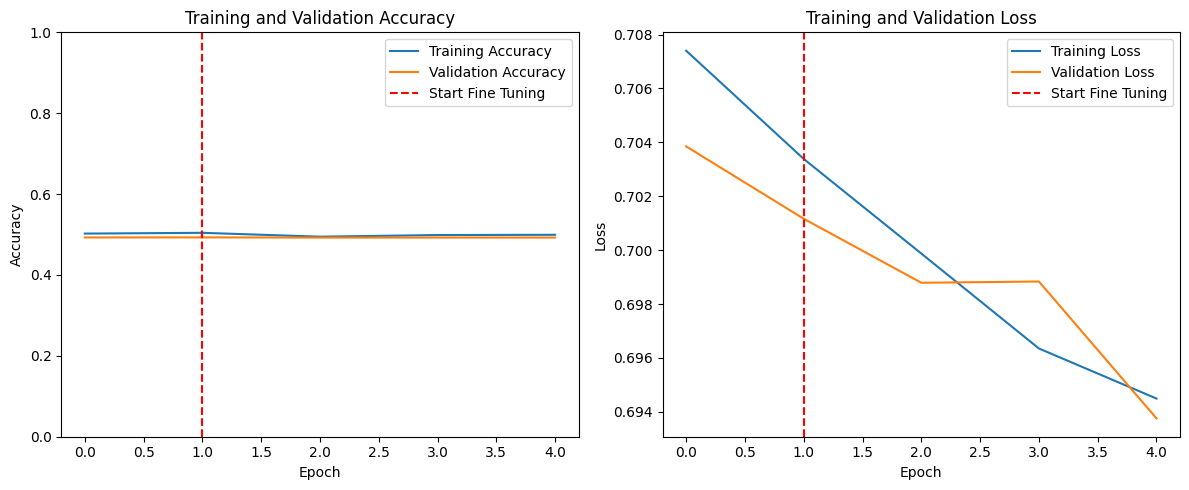


=== 7. Final Model Evaluation ===
626/626 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4886 - loss: 0.6939
Final Validation Accuracy: 0.4925
Final Validation Loss: 0.6938


In [3]:
# Fine-tuning a Pretrained Backbone with Keras NLP
# --- VERSION WITH OPTIMIZATIONS ---

import tensorflow as tf
import keras_nlp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import os
import math # For ceiling division

print("TensorFlow version:", tf.__version__)
print("Keras NLP version:", keras_nlp.__version__)

# --- Configuration ---
# Dataset
dataset_dir = "aclImdb" # Make sure this directory exists
# Model & Sequence Length
# Consider smaller models like "distilbert_base_en_uncased" if memory is tight
# PRESET = "distilbert_base_en_uncased"
PRESET = "bert_base_en_uncased"
# Try reducing sequence length (e.g., 256, 128) if memory is an issue and texts allow
max_sequence_length = 256
# Training Hyperparameters
BATCH_SIZE = 16 # Reduced batch size to save memory (adjust based on your GPU)
INITIAL_EPOCHS = 2 # Epochs for training the head
FINE_TUNE_EPOCHS = 3 # Epochs for fine-tuning the whole model
INITIAL_LR = 1e-4 # Learning rate for initial head training
END_LR = 1e-7 # End learning rate for decay schedule during fine-tuning
# Learning rate for fine-tuning - will be overwritten by schedule if enabled
# FINE_TUNE_LR = 5e-5
WEIGHT_DECAY = 0.01 # Weight decay for AdamW
WARMUP_RATE = 0.1 # Proportion of fine-tuning steps for warmup
ENABLE_LR_SCHEDULE = True # Set to False to use fixed FINE_TUNE_LR
# Mixed Precision (requires compatible GPU - e.g., T4, V100, A100)
ENABLE_MIXED_PRECISION = True

# --- (Optional) Enable Mixed Precision Training ---
if ENABLE_MIXED_PRECISION:
    try:
        print("\n=== Enabling Mixed Precision Training (float16) ===")
        keras.mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision policy set to 'mixed_float16'.")
        # Note: Ensure your GPU supports float16 operations for performance benefits.
    except Exception as e:
        print(f"Could not enable mixed precision: {e}. Continuing with float32.")
        ENABLE_MIXED_PRECISION = False # Fallback if policy setting fails

# --- 1. Load and Prepare Dataset ---
print("\n=== 1. Loading and Preparing Dataset ===")
if not os.path.exists(dataset_dir):
    print(f"ERROR: Dataset directory '{dataset_dir}' not found.")
    print("Please download the IMDB dataset (aclImdb_v1.tar.gz) and extract it.")
    raise FileNotFoundError(f"Dataset directory '{dataset_dir}' not found.")

# Load raw text data directly into tf.data.Dataset objects
train_ds, validation_ds = keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=BATCH_SIZE, # Use config variable
    validation_split=0.2,
    subset="both",
    seed=42,
)

# Get dataset sizes for LR schedule calculation (more robust than hardcoding)
try:
    num_train_examples = tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE
    num_val_examples = tf.data.experimental.cardinality(validation_ds).numpy() * BATCH_SIZE
    # Note: Cardinality might be infinite/unknown if dataset ops aren't fully defined yet.
    # If it fails, fall back to info printed during loading (usually reliable here)
    if num_train_examples <= 0: raise ValueError("Cardinality failed")
    print(f"Detected {num_train_examples} training examples, {num_val_examples} validation examples.")
except:
    print("Could not determine dataset size via cardinality, using loading info.")
    # Use info from loading printout (update if your split/dataset changes)
    num_train_examples = 40004
    num_val_examples = 10001
    print(f"Using assumed sizes: {num_train_examples} training, {num_val_examples} validation.")


print(f"Training dataset specs: {train_ds.element_spec}")
print(f"Validation dataset specs: {validation_ds.element_spec}")

# Apply caching and prefetching for performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- 2. Load Pretrained Backbone & Preprocessor ---
print(f"\n=== 2. Loading Pretrained Backbone & Preprocessor ({PRESET}) ===")

# Use specific preprocessor/backbone based on PRESET
if "distilbert" in PRESET:
    PreprocessorClass = keras_nlp.models.DistilBertPreprocessor
    BackboneClass = keras_nlp.models.DistilBertBackbone
elif "bert" in PRESET:
    PreprocessorClass = keras_nlp.models.BertPreprocessor
    BackboneClass = keras_nlp.models.BertBackbone
else:
    raise ValueError(f"Unsupported preset type: {PRESET}")

preprocessor = PreprocessorClass.from_preset(
    PRESET,
    sequence_length=max_sequence_length,
)
backbone = BackboneClass.from_preset(PRESET)


# --- 3. Build the Fine-tuning Model ---
print("\n=== 3. Building the Fine-tuning Model ===")

inputs = keras.Input(shape=(), dtype="string", name="text_input")
preprocessed_inputs = preprocessor(inputs)
backbone_outputs = backbone(preprocessed_inputs)

# Use pooled_output if available and suitable (often pre-processed for classification)
# Otherwise, fallback to CLS token from sequence_output
if "pooled_output" in backbone_outputs:
     # Check if pooled_output is valid (might be None for some models/configs)
    if backbone_outputs["pooled_output"] is not None:
        print("Using 'pooled_output' from backbone.")
        sequence_representation = backbone_outputs["pooled_output"]
    else: # Fallback if pooled_output is None
         print("Using 'sequence_output[:, 0, :]' (CLS token) as pooled_output was None.")
         sequence_representation = backbone_outputs["sequence_output"][:, 0, :]
else: # Fallback if key doesn't exist
    print("Using 'sequence_output[:, 0, :]' (CLS token).")
    sequence_representation = backbone_outputs["sequence_output"][:, 0, :]

# Add dropout and classification head
intermediate_output = keras.layers.Dropout(0.1)(sequence_representation)
# Use float32 for the final Dense layer when using mixed precision for stability
outputs = keras.layers.Dense(1, activation="sigmoid", name="classifier_head", dtype=tf.float32)(intermediate_output)

model = keras.Model(inputs, outputs)
model.summary()


# --- 4. Initial Training with Frozen Backbone ---
print("\n=== 4. Training with Frozen Backbone (Warm-up) ===")
print("Initially freezing the backbone layers...")
backbone.trainable = False

# OPTIMIZATION: Use AdamW optimizer
optimizer_frozen = keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=WEIGHT_DECAY,
    # clipnorm=1.0 # Optional: gradient clipping
)
# Loss needs to be float32 when using mixed precision
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False) # Sigmoid applied

model.compile(
    optimizer=optimizer_frozen,
    loss=loss_fn,
    metrics=["accuracy"],
    jit_compile=False # Keep False to avoid XLA string issues
)

print(f"Training head for {INITIAL_EPOCHS} epochs...")
start_time = time.time()
history_frozen = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_ds,
)
end_time = time.time()
print(f"Time taken for training with frozen backbone: {end_time - start_time:.2f} seconds")


# --- 5. Fine-tuning the Entire Model ---
print("\n=== 5. Fine-tuning the Entire Model ===")
print("Unfreezing the backbone layers...")
backbone.trainable = True

# OPTIMIZATION: Calculate steps for LR schedule
steps_per_epoch = math.ceil(num_train_examples / BATCH_SIZE)
fine_tune_steps = steps_per_epoch * FINE_TUNE_EPOCHS
warmup_steps = int(WARMUP_RATE * fine_tune_steps)
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total fine-tune steps: {fine_tune_steps}")
print(f"Warmup steps: {warmup_steps}")

if ENABLE_LR_SCHEDULE:
    print("Using learning rate schedule with linear decay and warmup.")
    # Start LR is the peak LR after warmup
    start_lr_schedule = INITIAL_LR # Or use FINE_TUNE_LR if defined separately

    # Create Polynomial Decay schedule (often used, approximates linear)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=start_lr_schedule,
        decay_steps=fine_tune_steps - warmup_steps, # Steps after warmup
        end_learning_rate=END_LR,
        power=1.0, # Power 1.0 is linear decay
    )

    # Apply warmup phase
    if warmup_steps > 0:
        warmup_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
             initial_learning_rate=1e-9, # Start from near zero
             decay_steps=warmup_steps,
             end_learning_rate=start_lr_schedule,
             power=1.0
        )
        # Combine warmup and decay
        # Note: Keras schedules are based on step counts directly
        # We need to manually switch based on step or use a custom schedule wrapper
        # For simplicity here, we might just use AdamW's internal schedule capabilities if simpler,
        # or accept that PolynomialDecay starts decay immediately after warmup peak.
        # A simpler approximation using AdamW's beta_1 for warmup isn't standard.
        # Let's stick to the PolynomialDecay but acknowledge the warmup integration isn't perfect via built-ins easily.
        # A more robust way involves custom schedule objects or optimizers with built-in warmup+decay.
        # Let's just use the decay part for now, starting from peak LR, assuming warmup happens implicitly or via optimizer properties
        # Reverting to a simpler setup for PolynomialDecay post-warmup:
        lr_schedule_post_warmup = tf.keras.optimizers.schedules.PolynomialDecay(
             initial_learning_rate=start_lr_schedule, # Peak LR
             decay_steps=fine_tune_steps - warmup_steps,
             end_learning_rate=END_LR,
             power=1.0
        )
        # We'll pass this to AdamW. Warmup needs custom handling or specific optimizer support usually.
        # Keras's AdamW doesn't have built-in linear warmup + decay schedule.
        # For demonstration, we proceed with decay from peak LR. Actual warmup requires more code.
        print(f"WARNING: Using PolynomialDecay starting from peak LR ({start_lr_schedule}). Proper warmup requires custom schedule.")
        final_learning_rate = lr_schedule_post_warmup # Use the decay schedule
else:
    print(f"Using fixed learning rate: {INITIAL_LR}") # Use initial LR as FINE_TUNE_LR wasn't set
    final_learning_rate = INITIAL_LR

# OPTIMIZATION: Use AdamW optimizer
optimizer_tuned = keras.optimizers.AdamW(
    learning_rate=final_learning_rate, # Use schedule or fixed LR
    weight_decay=WEIGHT_DECAY,
    # clipnorm=1.0 # Optional: gradient clipping
)

model.compile(
    optimizer=optimizer_tuned,
    loss=loss_fn, # Reuse loss from before
    metrics=["accuracy"],
    jit_compile=False # Keep False
)

print("\nContinuing training (fine-tuning) with unfrozen backbone...")
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
start_time = time.time()
history_unfrozen = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=INITIAL_EPOCHS, # Start counting from here
    validation_data=validation_ds,
)
end_time = time.time()
print(f"Time taken for fine-tuning: {end_time - start_time:.2f} seconds")


# --- 6. Visualize Training History ---
# (Plotting code remains the same as previous version)
print("\n=== 6. Visualizing Training History ===")
history = {}
try:
    # Combine histories only if both phases ran successfully
    history["accuracy"] = history_frozen.history["accuracy"] + history_unfrozen.history["accuracy"]
    history["val_accuracy"] = history_frozen.history["val_accuracy"] + history_unfrozen.history["val_accuracy"]
    history["loss"] = history_frozen.history["loss"] + history_unfrozen.history["loss"]
    history["val_loss"] = history_frozen.history["val_loss"] + history_unfrozen.history["val_loss"]
except KeyError as e:
     print(f"Warning: Could not combine histories completely due to missing key: {e}. Plotting might be incomplete.")
     history = history_unfrozen.history # Plot only the fine-tuning part if frozen part failed

if history and "accuracy" in history: # Check if history is usable
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Training Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.axvline(x=INITIAL_EPOCHS-1, color="r", linestyle="--", label="Start Fine Tuning")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1]) # Standardize y-axis for accuracy
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.axvline(x=INITIAL_EPOCHS-1, color="r", linestyle="--", label="Start Fine Tuning")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plotting as history data is missing or incomplete.")


# --- 7. Final Model Evaluation ---
print("\n=== 7. Final Model Evaluation ===")
loss, accuracy = model.evaluate(validation_ds)
# If using mixed precision, accuracy might be float16, convert for display
accuracy = float(accuracy)
loss = float(loss)
print(f"Final Validation Accuracy: {accuracy:.4f}")
print(f"Final Validation Loss: {loss:.4f}")



In [4]:

# --- 8. Testing on New Examples ---
# (Testing code remains the same)
print("\n=== 8. Testing on New Examples ===")
test_examples = [
    "This movie was fantastic! I really enjoyed the plot and the acting was superb.",
    "What a waste of time. Poor acting, terrible script, and boring storyline.",
    "The movie had good special effects but the story was somewhat confusing.",
    "I fell asleep halfway through the movie.",
    "The characters were well-developed and the dialogue was engaging."
]
predictions = model.predict(tf.constant(test_examples))
for i, (text, pred) in enumerate(zip(test_examples, predictions)):
    pred_value = float(pred[0]) # Ensure float for comparison
    sentiment = "Positive" if pred_value >= 0.5 else "Negative"
    confidence = pred_value if sentiment == "Positive" else 1 - pred_value
    print(f"\nExample {i+1}: {text}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.4f})")


# --- 9. Saving the Fine-tuned Model ---
# (Saving code remains largely the same)
print("\n=== 9. Saving the Fine-tuned Model ===")
model_save_path = f"./{PRESET}_imdb_finetuned.keras" # Dynamic name based on preset
try:
    model.save(model_save_path)
    print(f"Model saved successfully to {model_save_path}")

    # Optional: Test loading the saved model
    print("\nTesting loading the saved model...")
    # When loading mixed precision models, custom objects usually not needed
    # but good practice if complex layers were added
    loaded_model = keras.models.load_model(model_save_path)
    print("Model loaded successfully.")
    loaded_pred = loaded_model.predict(["A quick test after loading."])
    print(f"Test prediction with loaded model: {float(loaded_pred[0][0]):.4f}")

except Exception as e:
    print(f"Error saving or loading model: {e}")


# --- Tips ---
# (Tips remain the same)
print("\n=== Tips for Improving Fine-tuning Results ===")
# ... (tips copied from previous version) ...
print("1. Use longer training with more epochs (monitor validation loss for overfitting)")
print("2. Experiment with different learning rates or learning rate schedules (e.g., linear decay)")
print("3. Try larger batch sizes if your GPU memory allows (or use gradient accumulation)")
print("4. Explore gradual unfreezing (unfreeze layer groups incrementally)")
print("5. Apply techniques like weight decay (AdamW helps here)")
print("6. Use longer maximum sequence length if needed and memory allows")
print("7. Consider data augmentation techniques for text (e.g., back-translation, synonym replacement)")
print("8. Try different pretrained backbones (e.g., RoBERTa, DistilBERT, ELECTRA)")


print(f"\nComplete! Optimized fine-tuning script finished for {PRESET}.")


=== 8. Testing on New Examples ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Example 1: This movie was fantastic! I really enjoyed the plot and the acting was superb.
Prediction: Positive (confidence: 0.5115)

Example 2: What a waste of time. Poor acting, terrible script, and boring storyline.
Prediction: Positive (confidence: 0.5115)

Example 3: The movie had good special effects but the story was somewhat confusing.
Prediction: Positive (confidence: 0.5115)

Example 4: I fell asleep halfway through the movie.
Prediction: Positive (confidence: 0.5116)

Example 5: The characters were well-developed and the dialogue was engaging.
Prediction: Positive (confidence: 0.5115)

=== 9. Saving the Fine-tuned Model ===
Model saved successfully to ./bert_base_en_uncased_imdb_finetuned.keras

Testing loading the saved model...
Error saving or loading model: Exception encountered when calling BertTextClassifierPreprocessor.call().

Could not automatically infer the output shape / dtype of 'bert_text_cl